# 102Flowers Image Classifier

This is the main notebook for the project. See the associated report (WIP) for more information.

### Imports

In [15]:
import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torchvision import datasets, transforms, models

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy

import ssl
ssl._create_default_https_context = ssl._create_unverified_context

### Hyperparameters

In [46]:
# TODO: Set hyperparameters.
training_batch_size = 64
validation_batch_size = 64
test_batch_size = 64
epochs = 0
learning_rate = 0

### Device

In [40]:
# Default to CPU
device = torch.device("cpu")

# Switch to GPU if available
if torch.cuda.is_available():
	print(f"Found {torch.cuda.device_count()} GPUs. Using cuda:0.")
	device = torch.device("cuda:0")
else:
	print("No GPUs found, using CPU.")

No GPUs found, using CPU.


### Load Dataset

In [41]:
training_data = datasets.Flowers102(
    root = "data",
    split = "train",
    transform=transforms.ToTensor(),
    download=True
)

validation_data = datasets.Flowers102(
    root = "data",
    split = "val",
    transform=transforms.ToTensor(),
    download=True
)

testing_data = datasets.Flowers102(
    root = "data",
    split = "test",
    transform=transforms.ToTensor(),
    download=True
)

### DataLoaders

In [47]:
train_dataloader = DataLoader(training_data, batch_size=training_batch_size, shuffle=True)
validation_dataloader = DataLoader(validation_data, batch_size=validation_batch_size, shuffle=True)
test_dataloader = DataLoader(testing_data, batch_size=test_batch_size, shuffle=True)   

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break 

RuntimeError: stack expects each tensor to be equal size, but got [3, 500, 526] at entry 0 and [3, 500, 667] at entry 1

## Model

In [20]:
onehot = F.one_hot(torch.tensor([e for e in range(0,102)]), num_classes=102)
onehot

tensor([[1, 0, 0,  ..., 0, 0, 0],
        [0, 1, 0,  ..., 0, 0, 0],
        [0, 0, 1,  ..., 0, 0, 0],
        ...,
        [0, 0, 0,  ..., 1, 0, 0],
        [0, 0, 0,  ..., 0, 1, 0],
        [0, 0, 0,  ..., 0, 0, 1]])

In [23]:
class F102Classifier(nn.Module):
	def __init__(self):
		super(F102Classifier, self).__init__()

model = F102Classifier()

TypeError: Invalid shape (3, 567, 500) for image data

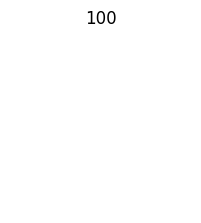

In [25]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()